# Group Number: 32

# Student 1: Ryan Meghoe

# Student 2: Nikita Jain

# Student 3: Andrei Rykov

# Downloading Data and Preliminaries


In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from zipfile import ZipFile
import requests
import io

In [2]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_pickle(zipfile, fn):
    return pickle.load(io.BytesIO(zipfile[fn]))

In [3]:
data = load_zip('https://surfdrive.surf.nl/files/index.php/s/cwqGaS22KXgnXtg/download')

    
"""
simulation_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_train = load_pickle(data, 'data/train/simulation.pickle')  # 3.1 + 3.2
simulation_valid = load_pickle(data, 'data/valid/simulation.pickle')  # 3.1 + 3.2
simulation_test = load_pickle(data, 'data/test/simulation.pickle')  # 3.1 + 3.2

"""
charges_{train, valid, test} is stored as a list of simulation-charges. 
These charges are stored as numpy arrays of size (3,): One value for each charge.
"""
charges_train = load_pickle(data, 'data/train/charges.pickle')  # 3.1
charges_valid = load_pickle(data, 'data/valid/charges.pickle')  # 3.1
charges_test = load_pickle(data, 'data/test/charges.pickle')  # 3.1

"""
simulation_continued_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_continued_train = load_pickle(data, 'data/train/simulation_continued.pickle')  # 3.2
simulation_continued_valid = load_pickle(data, 'data/valid/simulation_continued.pickle')  # 3.2
simulation_continued_test = load_pickle(data, 'data/test/simulation_continued.pickle')  # 3.2

"""
Note that the indices are shared throughout the different lists, e.g., for the 4th training simulation:
simulation_train[3] contains its initial simulation
charges_train[3] contains the charges associated with the simulation
simulation_continued_train[3] contains the continuation of the simulation 
                --> simulation_continued_train[3][0] is the state after simulation_train[3][-1]
"""
pass

In [4]:
print('Overview of no. datapoints:\n')

print('Task 3.1:')
print(f'{len(simulation_train)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(charges_train)} train, {len(charges_valid)} validation, {len(charges_test)} test charge pairs')
print()

print('Task 3.2:')
print('Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations')
print('We cut simulation_train down to the first 150 samples in simulation_train_task32')
simulation_train_task32 = simulation_train[:150]
print(f'{len(simulation_train_task32)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(simulation_continued_train)} train, {len(simulation_continued_valid)} validation, {len(simulation_continued_test)} test continuations')

print(f"""
For task 3.1, use:
{chr(10).join(["simulation_{} + charges_{}".format(t, t) for t in ["train", "valid", "test"]])}

For task 3.2, use:
{chr(10).join(["simulation_{} + simulation_continued_{}".format(*((t[0], t[1]) if isinstance(t, tuple) else (t, t))) for t in [("train_task32", "train"), "valid", "test"]])}
""")


Overview of no. datapoints:

Task 3.1:
800 train, 100 validation, 100 test simulations
800 train, 100 validation, 100 test charge pairs

Task 3.2:
Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations
We cut simulation_train down to the first 150 samples in simulation_train_task32
150 train, 100 validation, 100 test simulations
150 train, 100 validation, 100 test continuations

For task 3.1, use:
simulation_train + charges_train
simulation_valid + charges_valid
simulation_test + charges_test

For task 3.2, use:
simulation_train_task32 + simulation_continued_train
simulation_valid + simulation_continued_valid
simulation_test + simulation_continued_test



In [5]:
print('Print some shapes:\n')
for i in range(3):
    print('simulation_train[{}].shape:'.format(i), simulation_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('charges_train[{}].shape:'.format(i), charges_train[i].shape, '-> charges for the simulation')
    print('simulation_continued_train[{}].shape:'.format(i), simulation_continued_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('----\n')

Print some shapes:

simulation_train[0].shape: (103, 2) -> (t, 2), (x, y) at every t)
charges_train[0].shape: (3,) -> charges for the simulation
simulation_continued_train[0].shape: (54, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[1].shape: (97, 2) -> (t, 2), (x, y) at every t)
charges_train[1].shape: (3,) -> charges for the simulation
simulation_continued_train[1].shape: (45, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[2].shape: (99, 2) -> (t, 2), (x, y) at every t)
charges_train[2].shape: (3,) -> charges for the simulation
simulation_continued_train[2].shape: (47, 2) -> (t, 2), (x, y) at every t)
----



In [6]:
def plot_example(x, x_gt=None, x_pred=None, fn=None):
    charge_locations = np.array([[-1.53846154, -1.53846154],
                                 [ 1.53846154, -1.53846154],
                                 [ 0.        ,  1.53846154]])  # charge locations are fixed
    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    cmap = matplotlib.cm.get_cmap('tab20')
    plt.plot(x[:, 0], x[:, 1], color=cmap(0))
    plt.plot(x[0, 0], x[0, 1], 'd', color=cmap(1))
    fig.set_size_inches(5, 5)
    for charge in charge_locations:
        plt.plot(charge[0], charge[1], 'd', color='black')
    if x_gt is not None:
        plt.plot(x_gt[:, 0], x_gt[:, 1], color='red', linewidth=.5)
    if x_pred is not None:
        plt.plot(x_pred[:, 0], x_pred[:, 1], color='green', linestyle='--')
    if fn is None:
        plt.show()
    else:
        plt.savefig(fn)

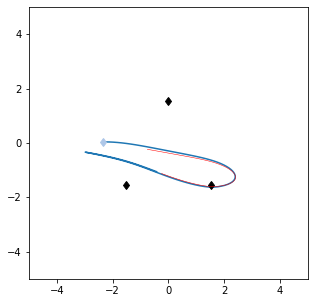

Charges are [-0.95420408 -0.57435255 -0.99420185]


In [7]:
test_idx = np.random.randint(150)
plot_example(simulation_train[test_idx], simulation_continued_train[test_idx])
print(f'Charges are {charges_train[test_idx]}')

## Data Handling and Preprocessing

In [8]:
import torch.nn.functional as f
import torch

lengths_train = torch.Tensor(list(map(lambda x: x.shape[0], simulation_continued_train))).unsqueeze(-1)
lengths_valid = torch.Tensor(list(map(lambda x: x.shape[0], simulation_continued_valid))).unsqueeze(-1)
lengths_test = torch.Tensor(list(map(lambda x: x.shape[0], simulation_continued_test))).unsqueeze(-1)


simulation_train = torch.cat(list(map(lambda x: f.pad(torch.Tensor(x), pad=(0, 0, 110 - x.shape[0], 0)).unsqueeze(0), simulation_train)))
simulation_valid = torch.cat(list(map(lambda x: f.pad(torch.Tensor(x), pad=(0, 0, 110 - x.shape[0], 0)).unsqueeze(0), simulation_valid)))
simulation_test = torch.cat(list(map(lambda x: f.pad(torch.Tensor(x), pad=(0, 0, 110 - x.shape[0], 0)).unsqueeze(0), simulation_test)))


simulation_continued_train = torch.cat(list(map(lambda x: f.pad(torch.Tensor(x), pad=(0, 0, 0, 60 - x.shape[0])).unsqueeze(0), simulation_continued_train)))
simulation_continued_valid = torch.cat(list(map(lambda x: f.pad(torch.Tensor(x), pad=(0, 0, 0, 60 - x.shape[0])).unsqueeze(0), simulation_continued_valid)))
simulation_continued_test = torch.cat(list(map(lambda x: f.pad(torch.Tensor(x), pad=(0, 0, 0, 60 - x.shape[0])).unsqueeze(0), simulation_continued_test)))


charges_train = torch.cat(list(map(lambda x: torch.Tensor(x).unsqueeze(0), charges_train)))
charges_valid = torch.cat(list(map(lambda x: torch.Tensor(x).unsqueeze(0), charges_valid)))
charges_test = torch.cat(list(map(lambda x: torch.Tensor(x).unsqueeze(0), charges_test)))

In [9]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset_31 = TensorDataset(simulation_train, charges_train)
valid_dataset_31 = TensorDataset(simulation_valid, charges_valid)
test_dataset_31 = TensorDataset(simulation_test, charges_test)

train_dataset_32 = TensorDataset(simulation_train[:simulation_continued_train.shape[0]], simulation_continued_train, lengths_train)
valid_dataset_32 = TensorDataset(simulation_valid[:simulation_continued_valid.shape[0]], simulation_continued_valid, lengths_valid)
test_dataset_32 = TensorDataset(simulation_test[:simulation_continued_test.shape[0]], simulation_continued_test, lengths_test)

In [10]:
batch_size = 64

train_dataloader_31 = DataLoader(train_dataset_31, batch_size=batch_size, shuffle=True)
valid_dataloader_31 = DataLoader(valid_dataset_31, batch_size=batch_size, shuffle=False)
test_dataloader_31 = DataLoader(test_dataset_31, batch_size=batch_size, shuffle=False)

train_dataloader_32 = DataLoader(train_dataset_32, batch_size=batch_size, shuffle=True)
valid_dataloader_32 = DataLoader(valid_dataset_32, batch_size=batch_size, shuffle=False)
test_dataloader_32 = DataLoader(test_dataset_32, batch_size=batch_size, shuffle=False)

# Task 3.1

## Model Implementation

In [37]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, coord_shape, emb_dim, hid_dim, n_layers, dropout):
        super(Encoder, self).__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        ### Your code here ###
        self.embedding = nn.Sequential(nn.Linear(coord_shape, emb_dim),
                                       nn.Dropout(dropout))
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout, batch_first = True)
        
    def forward(self, x):
        
        x = self.embedding(x)
        _, (hidden, cell) = self.rnn(x)

        return hidden, cell



In [38]:
class SequenceToCharge(nn.Module):
    def __init__(self, coord_shape, emb_dim, hid_dim, n_layers, dropout,
                 output_shape):
        super(SequenceToCharge, self).__init__()

        self.encoder = Encoder(coord_shape, emb_dim, hid_dim, n_layers, dropout)

        self.dense = nn.Sequential(nn.Linear(hid_dim, 64),
                                   nn.ReLU(),
                                   nn.Dropout(0.6),
                                   nn.Linear(64, output_shape),
                                   nn.Sigmoid()
                                  )

    def forward(self, particle_trajectory):
        hidden, _ = self.encoder(particle_trajectory)
        output = self.dense(hidden[-1])

        return output - 1

## Model Training

In [39]:
from tqdm import tqdm

class Trainer31():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset ,
                 testing_DataLoader: torch.utils.data.Dataset ,
                 epochs: int
                 ):
        
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.testing_DataLoader = testing_DataLoader
        self.device = device
        self.epochs = epochs


    def run_trainer(self):

        epoch_train_losses = []
        epoch_val_losses = []

        for epoch in tqdm(range(self.epochs)):
                 

            self.model.train()  # train mode

            train_losses=[]
            
            correct = 0
            length = 0
            for x, y in self.training_DataLoader:

                sequence, charges = x.float().to(self.device), y.float().to(self.device) # send to device (GPU or CPU)

                self.optimizer.zero_grad()  # zerograd the parameters

                loss = 0
                out = self.model(sequence)  # one forward pass

                loss += self.criterion(out, charges)  # calculate loss
                
                loss_value = loss.item()
                train_losses.append(loss_value)
                 
                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters
            
            epoch_train_losses.append(np.mean(train_losses))
            self.model.eval()  # evaluation mode
            valid_losses = []  # accumulate the losses here

            correct = 0
            length = 0
            for x,  y in self.validation_DataLoader:

                sequence, charges = x.float().to(self.device), y.float().to(self.device) # send to device (GPU or CPU)

                with torch.no_grad():
                    loss = 0
                    
                    out = self.model(sequence)  # one forward pass
                    loss += self.criterion(out, charges)  # calculate loss
                 
                    loss_value = loss.item()
                    valid_losses.append(loss_value)

            epoch_val_losses.append(np.mean(valid_losses))
                
            # print the results
            print(
                f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'LOSS: {np.mean(train_losses):.4f}',end=' ')
            print(f'VAL-LOSS: {np.mean(valid_losses):.4f}',end='\n')

        return epoch_train_losses, epoch_val_losses
        
    def evaluate(self):

        self.model.eval()

        with torch.no_grad():
            loss = []
            length = 0
            for x,y in self.testing_DataLoader:
                
                sequence, charges = x.float().to(self.device), y.float().to(self.device)
                out = self.model(sequence)
                loss.append(self.criterion(out, charges))
                
        print(f'Error: {np.mean(loss):.4f}')
        
    def evaluate_train(self):

        self.model.eval()

        with torch.no_grad():
            loss = []
            length = 0
            for x,y in self.training_DataLoader:
                
                sequence, charges = x.float().to(self.device), y.float().to(self.device)
                out = self.model(sequence)
                loss.append(self.criterion(out, charges))
                
        print(f'Error: {np.mean(loss):.4f}')

## Evaluation

In [42]:
if torch.cuda.is_available():
        device = torch.device('cuda')
else:
        device=torch.device('cpu')

model = SequenceToCharge(coord_shape = 2, emb_dim = 8, hid_dim = 16, n_layers = 1, dropout = 0.5, 
                         output_shape = 3).to(device)
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

TrainingProcedure = Trainer31(model, 
                                device, 
                                criterion, 
                                optimizer,
                                train_dataloader_31,
                                valid_dataloader_31,
                                test_dataloader_31,
                                epochs = 25)

train_loss, val_loss = TrainingProcedure.run_trainer()
TrainingProcedure.evaluate()
TrainingProcedure.evaluate_train()

  4%|███▎                                                                               | 1/25 [00:00<00:09,  2.56it/s]

EPOCH: 01/25 LOSS: 0.2463 VAL-LOSS: 0.2645


  8%|██████▋                                                                            | 2/25 [00:00<00:09,  2.45it/s]

EPOCH: 02/25 LOSS: 0.2441 VAL-LOSS: 0.2599


 12%|█████████▉                                                                         | 3/25 [00:01<00:08,  2.46it/s]

EPOCH: 03/25 LOSS: 0.2398 VAL-LOSS: 0.2581


 16%|█████████████▎                                                                     | 4/25 [00:01<00:08,  2.39it/s]

EPOCH: 04/25 LOSS: 0.2409 VAL-LOSS: 0.2625


 20%|████████████████▌                                                                  | 5/25 [00:02<00:08,  2.40it/s]

EPOCH: 05/25 LOSS: 0.2382 VAL-LOSS: 0.2547


 24%|███████████████████▉                                                               | 6/25 [00:02<00:07,  2.40it/s]

EPOCH: 06/25 LOSS: 0.2368 VAL-LOSS: 0.2509


 28%|███████████████████████▏                                                           | 7/25 [00:02<00:07,  2.43it/s]

EPOCH: 07/25 LOSS: 0.2342 VAL-LOSS: 0.2458


 32%|██████████████████████████▌                                                        | 8/25 [00:03<00:07,  2.38it/s]

EPOCH: 08/25 LOSS: 0.2306 VAL-LOSS: 0.2399


 36%|█████████████████████████████▉                                                     | 9/25 [00:03<00:06,  2.31it/s]

EPOCH: 09/25 LOSS: 0.2248 VAL-LOSS: 0.2309


 40%|████████████████████████████████▊                                                 | 10/25 [00:04<00:06,  2.25it/s]

EPOCH: 10/25 LOSS: 0.2256 VAL-LOSS: 0.2323


 44%|████████████████████████████████████                                              | 11/25 [00:04<00:06,  2.21it/s]

EPOCH: 11/25 LOSS: 0.2217 VAL-LOSS: 0.2436


 48%|███████████████████████████████████████▎                                          | 12/25 [00:05<00:05,  2.27it/s]

EPOCH: 12/25 LOSS: 0.2295 VAL-LOSS: 0.2257


 52%|██████████████████████████████████████████▋                                       | 13/25 [00:05<00:05,  2.27it/s]

EPOCH: 13/25 LOSS: 0.2218 VAL-LOSS: 0.2225


 56%|█████████████████████████████████████████████▉                                    | 14/25 [00:06<00:04,  2.27it/s]

EPOCH: 14/25 LOSS: 0.2203 VAL-LOSS: 0.2191


 60%|█████████████████████████████████████████████████▏                                | 15/25 [00:06<00:04,  2.34it/s]

EPOCH: 15/25 LOSS: 0.2224 VAL-LOSS: 0.2184


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:06<00:03,  2.35it/s]

EPOCH: 16/25 LOSS: 0.2174 VAL-LOSS: 0.2162


 68%|███████████████████████████████████████████████████████▊                          | 17/25 [00:07<00:03,  2.35it/s]

EPOCH: 17/25 LOSS: 0.2146 VAL-LOSS: 0.2163


 72%|███████████████████████████████████████████████████████████                       | 18/25 [00:07<00:03,  2.31it/s]

EPOCH: 18/25 LOSS: 0.2073 VAL-LOSS: 0.2101


 76%|██████████████████████████████████████████████████████████████▎                   | 19/25 [00:08<00:02,  2.38it/s]

EPOCH: 19/25 LOSS: 0.2041 VAL-LOSS: 0.1949


 80%|█████████████████████████████████████████████████████████████████▌                | 20/25 [00:08<00:02,  2.34it/s]

EPOCH: 20/25 LOSS: 0.1953 VAL-LOSS: 0.1867


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:08<00:01,  2.34it/s]

EPOCH: 21/25 LOSS: 0.1924 VAL-LOSS: 0.1928


 88%|████████████████████████████████████████████████████████████████████████▏         | 22/25 [00:09<00:01,  2.28it/s]

EPOCH: 22/25 LOSS: 0.1954 VAL-LOSS: 0.1873


 92%|███████████████████████████████████████████████████████████████████████████▍      | 23/25 [00:09<00:00,  2.26it/s]

EPOCH: 23/25 LOSS: 0.1895 VAL-LOSS: 0.1924


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [00:10<00:00,  2.23it/s]

EPOCH: 24/25 LOSS: 0.1849 VAL-LOSS: 0.1855


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:10<00:00,  2.32it/s]

EPOCH: 25/25 LOSS: 0.1798 VAL-LOSS: 0.1744
Error: 0.1706
Error: 0.1650


### Look at the errors

In [47]:
predicted_charges = model(simulation_test)
indices = np.argsort(((predicted_charges - charges_test)**2).sqrt().mean(axis = 1).detach().numpy())[-5:]

Predicted Charges: tensor([-0.2247, -0.6952, -0.2003]), Actual Charges: tensor([-0.9535, -0.7526, -0.0825])
The length of the given sequence: 100


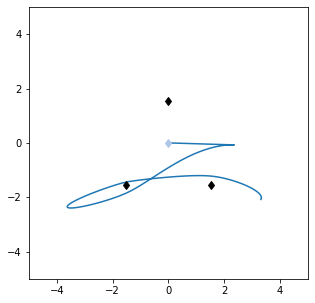

In [48]:
print(f'Predicted Charges: {predicted_charges[indices[0]].detach()}, Actual Charges: {charges_test[indices[0]]}')
print(f'The length of the given sequence: {((simulation_test[indices[0]] != 0).sum(axis = 1) > 0).sum().item()}')
plot_example(simulation_test[indices[0]])

Predicted Charges: tensor([-0.6234, -0.3900, -0.1427]), Actual Charges: tensor([-0.1228, -0.0967, -0.2784])
The length of the given sequence: 93


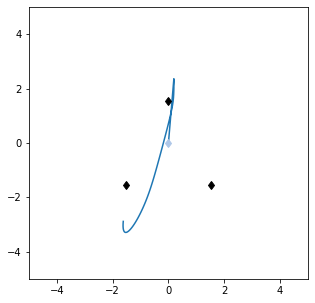

In [49]:
print(f'Predicted Charges: {predicted_charges[indices[1]].detach()}, Actual Charges: {charges_test[indices[1]]}')
print(f'The length of the given sequence: {((simulation_test[indices[1]] != 0).sum(axis = 1) > 0).sum().item()}')

plot_example(simulation_test[indices[1]])

Predicted Charges: tensor([-0.7460, -0.4963, -0.5088]), Actual Charges: tensor([-0.9233, -0.1502, -0.0910])
The length of the given sequence: 100


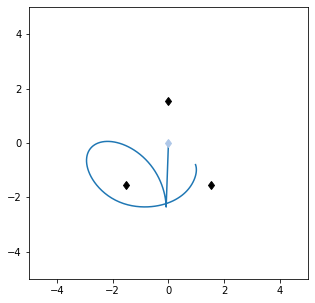

In [50]:
print(f'Predicted Charges: {predicted_charges[indices[2]].detach()}, Actual Charges: {charges_test[indices[2]]}')
print(f'The length of the given sequence: {((simulation_test[indices[2]] != 0).sum(axis = 1) > 0).sum().item()}')

plot_example(simulation_test[indices[2]])

Predicted Charges: tensor([-0.4695, -0.4723, -0.0735]), Actual Charges: tensor([-0.0670, -0.1208, -0.2702])
The length of the given sequence: 96


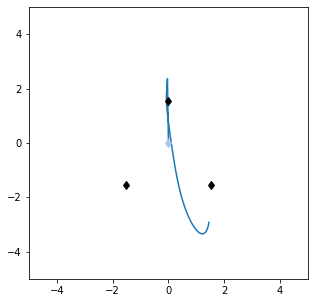

In [51]:
print(f'Predicted Charges: {predicted_charges[indices[3]].detach()}, Actual Charges: {charges_test[indices[3]]}')
print(f'The length of the given sequence: {((simulation_test[indices[3]] != 0).sum(axis = 1) > 0).sum().item()}')
plot_example(simulation_test[indices[3]])

Predicted Charges: tensor([-0.5917, -0.5259, -0.6212]), Actual Charges: tensor([-0.2383, -0.3075, -0.1021])
The length of the given sequence: 104


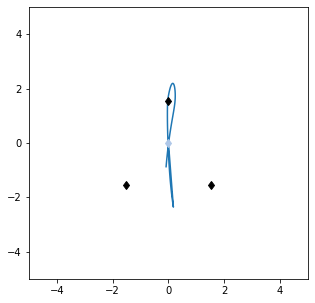

In [52]:
print(f'Predicted Charges: {predicted_charges[indices[4]].detach()}, Actual Charges: {charges_test[indices[4]]}')
print(f'The length of the given sequence: {((simulation_test[indices[4]] != 0).sum(axis = 1) > 0).sum().item()}')
plot_example(simulation_test[indices[4]])

#### The most precisely predicted examples

In [53]:
indices = np.argsort(((predicted_charges - charges_test)**2).sqrt().mean(axis = 1).detach().numpy())[:5]

Predicted Charges: tensor([-0.7669, -0.2791, -0.5056])
Actual Charges: tensor([-0.7552, -0.2015, -0.5135])


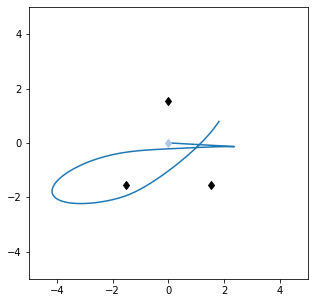

In [59]:
#print(f'Predicted Charges: {predicted_charges[indices[0]].detach()}, Actual Charges: {charges_test[indices[0]]}')
#print(f'The length of the given sequence: {((simulation_test[indices[0]] != 0).sum(axis = 1) > 0).sum().item()}')

print(f'Predicted Charges: {predicted_charges[indices[0]].detach()}')
print(f'Actual Charges: {charges_test[indices[0]]}')
plot_example(simulation_test[indices[0]])

Predicted Charges: tensor([-0.1806, -0.8127, -0.2214])
Actual Charges: tensor([-0.2351, -0.7718, -0.1956])


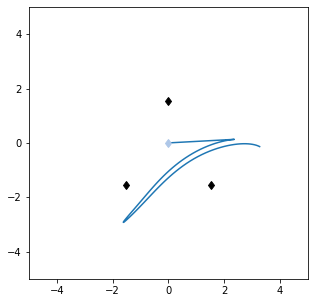

In [60]:
#print(f'Predicted Charges: {predicted_charges[indices[1]].detach()}, Actual Charges: {charges_test[indices[1]]}')
#print(f'The length of the given sequence: {((simulation_test[indices[1]] != 0).sum(axis = 1) > 0).sum().item()}')

print(f'Predicted Charges: {predicted_charges[indices[1]].detach()}')
print(f'Actual Charges: {charges_test[indices[1]]}')
plot_example(simulation_test[indices[1]])

Predicted Charges: tensor([-0.3386, -0.2514, -0.7079])
Actual Charges: tensor([-0.3362, -0.2264, -0.5834])


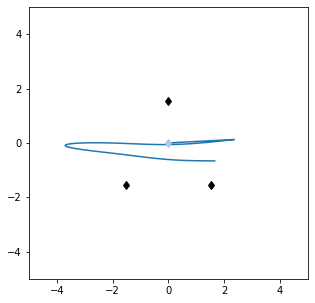

In [61]:
#print(f'Predicted Charges: {predicted_charges[indices[2]].detach()}, Actual Charges: {charges_test[indices[2]]}')
#print(f'The length of the given sequence: {((simulation_test[indices[2]] != 0).sum(axis = 1) > 0).sum().item()}')
print(f'Predicted Charges: {predicted_charges[indices[2]].detach()}')
print(f'Actual Charges: {charges_test[indices[2]]}')
plot_example(simulation_test[indices[2]])

Predicted Charges: tensor([-0.4562, -0.6797, -0.7136])
Actual Charges: tensor([-0.5242, -0.6315, -0.6610])


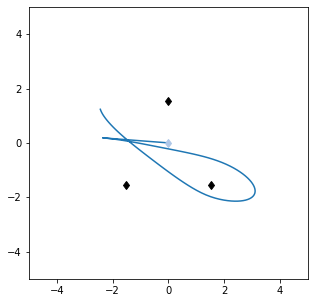

In [62]:
#print(f'Predicted Charges: {predicted_charges[indices[3]].detach()}, Actual Charges: {charges_test[indices[3]]}')
#print(f'The length of the given sequence: {((simulation_test[indices[3]] != 0).sum(axis = 1) > 0).sum().item()}')

print(f'Predicted Charges: {predicted_charges[indices[3]].detach()}')
print(f'Actual Charges: {charges_test[indices[3]]}')
plot_example(simulation_test[indices[3]])

Predicted Charges: tensor([-0.2598, -0.8670, -0.1738])
Actual Charges: tensor([-0.1416, -0.8942, -0.1479])


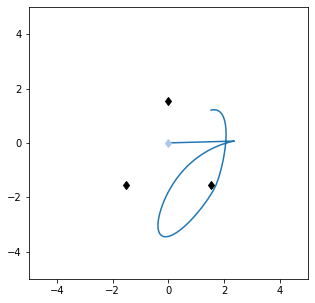

In [63]:
#print(f'Predicted Charges: {predicted_charges[indices[4]].detach()}, Actual Charges: {charges_test[indices[4]]}')
#print(f'The length of the given sequence: {((simulation_test[indices[4]] != 0).sum(axis = 1) > 0).sum().item()}')

print(f'Predicted Charges: {predicted_charges[indices[4]].detach()}')
print(f'Actual Charges: {charges_test[indices[4]]}')
plot_example(simulation_test[indices[4]])

# Task 3.2

## Model Implementation

In [64]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, coord_shape, emb_dim, hid_dim, n_layers, dropout):
        super(Encoder, self).__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        ### Your code here ###
        self.embedding = nn.Sequential(nn.Linear(coord_shape, emb_dim),
                                       nn.Dropout(dropout))
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout, batch_first = True)
        
    def forward(self, x):
        
        x = self.embedding(x)
        _, (hidden, cell) = self.rnn(x)

        return hidden, cell

In [65]:
class Decoder(nn.Module):
    def __init__(self, input_shape, hid_dim, n_layers, dropout):
        super(Decoder, self).__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.rnn = nn.LSTM(input_shape, hid_dim, n_layers, dropout=dropout, batch_first = True)

    def forward(self, x, hidden, cell):
        
        output, (hidden, cell) = self.rnn(x, (hidden, cell))

        return output, (hidden, cell)

In [162]:
import numpy as np 

class Seq2SeqARG(nn.Module):
    def __init__(self, coord_shape, emb_dim, hid_dim, n_layers, dropout, device = torch.device('cpu')):
        super(Seq2SeqARG, self).__init__()
        self.device = device

        self.encoder = Encoder(coord_shape, emb_dim, hid_dim, n_layers, dropout)

        self.decoder = Decoder(input_shape=coord_shape, hid_dim=hid_dim, n_layers=n_layers, dropout=dropout)

        self.dense = nn.Sequential(nn.Linear(hid_dim, 64),
                                   nn.ReLU(),
                                   nn.Dropout(0.5),
                                   nn.Linear(64, coord_shape))
                                  
    def forward(self, particle_trajectory, target_trajectory, teacher_forcing_ratio = 0.5):
        
        hidden, cell = self.encoder(particle_trajectory)

        predicted_target = torch.zeros((target_trajectory.shape)).to(self.device)

        previous = particle_trajectory[:,-1,:]
        for t in range(0, target_trajectory.shape[1]):
            
            output, (hidden, cell) = self.decoder(previous.view(particle_trajectory.shape[0], 1, -1), hidden, cell)
            # output = (batch_size, 1, hid_dim)

            predicted_target[:,t] = self.dense(output.view(particle_trajectory.shape[0], -1))

            # ground truth usage
            #decide if we are going to use teacher forcing or not
            teacher_force = np.random.rand(1)[0] > teacher_forcing_ratio
            #get the highest predicted token from our predictions
            top1 = target_trajectory[:,t]

            previous = predicted_target[:,t ] if teacher_force else top1
        
        return predicted_target

## Model Training

In [143]:
class Trainer32():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset ,
                 testing_DataLoader: torch.utils.data.Dataset ,
                 epochs: int
                 ):
        
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.testing_DataLoader = testing_DataLoader
        self.device = device
        self.epochs = epochs


    def run_trainer(self):

        epoch_train_losses = []
        epoch_val_losses = []

        for epoch in tqdm(range(self.epochs)):
                 

            self.model.train()  # train mode

            train_losses=[]
            
            correct = 0
            length = 0
            for x, y, z in self.training_DataLoader:

                x_sequence, y_sequence, lengths = x.float().to(self.device), y.float().to(self.device), z.float().to(self.device) # send to device (GPU or CPU)
                

                self.optimizer.zero_grad()  # zerograd the parameters

                loss = 0
                # out - (batch_size, sequence_length, coordinates)
                out = self.model(x_sequence, y_sequence)  # one forward pass

                #for pred,actual,seq_len in zip(out, y_sequence, lengths):

                #    loss += self.criterion(pred[:seq_len], actual[:seq_len])  # calculate loss

                mask = (torch.arange(60)[None, :] < lengths.view(-1)[:, None]).unsqueeze(-1)
                loss += torch.mean(torch.sum((out*mask - y_sequence).pow(2), dim=[1,2]) / lengths.view(-1))
                
                loss_value = loss.item()
                train_losses.append(loss_value)
                 
                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters
            
            epoch_train_losses.append(np.mean(train_losses))
            self.model.eval()  # evaluation mode
            valid_losses = []  # accumulate the losses here

            correct = 0
            length = 0
            for x, y, z in self.validation_DataLoader:

                x_sequence, y_sequence, lengths = x.float().to(self.device), y.float().to(self.device), z.float().to(self.device)

                with torch.no_grad():
                    loss = 0
                    
                    out = self.model(x_sequence, y_sequence)  # one forward pass
                    
                    mask = (torch.arange(60)[None, :] < lengths.view(-1)[:, None]).unsqueeze(-1)
                    loss += torch.mean(torch.sum((out*mask - y_sequence).pow(2), dim=[1,2]) / lengths.view(-1) ) # calculate loss
                 
                    loss_value = loss.item()
                    valid_losses.append(loss_value)

            epoch_val_losses.append(np.mean(valid_losses))
                
            # print the results
            print(
                f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'LOSS: {np.mean(train_losses):.4f}',end=' ')
            print(f'VAL-LOSS: {np.mean(valid_losses):.4f}',end='\n')

        return epoch_train_losses, epoch_val_losses
        
    def evaluate(self, teaching_force = 0):

        self.model.eval()

        with torch.no_grad():
            loss = []
            length = 0
            for x,y,z in self.testing_DataLoader:
                
                x_sequence, y_sequence, lengths = x.float().to(self.device), y.float().to(self.device), z.float().to(self.device)
                out = self.model(x_sequence, y_sequence, teaching_force)
                loss_batch = 0
                mask = (torch.arange(60)[None, :] < lengths.view(-1)[:, None]).unsqueeze(-1)
                loss_batch += torch.mean(torch.sum((out*mask - y_sequence).pow(2), dim=[1,2]) / lengths.view(-1)) 

                loss.append(loss_batch)
        print(f'Error: {np.mean(loss):.4f}')

## Evaluation

Train with 0.5 probability of teacher force

Evaluation is always without teacher force

With size of hidden layer in Dense equal to 64

In [163]:
if torch.cuda.is_available():
        device = torch.device('cuda')
else:
        device=torch.device('cpu')

model = Seq2SeqARG(coord_shape = 2, emb_dim = 8, hid_dim = 16, n_layers = 1, dropout = 0.25).to(device)
# placeholder
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

TrainingProcedure = Trainer32(model, 
                                device, 
                                criterion, 
                                optimizer,
                                train_dataloader_32,
                                valid_dataloader_32,
                                test_dataloader_32,
                                epochs = 30)

train_loss, val_loss = TrainingProcedure.run_trainer()
TrainingProcedure.evaluate(0)
TrainingProcedure.evaluate(1)

  3%|██▊                                                                                | 1/30 [00:00<00:09,  3.21it/s]

EPOCH: 01/30 LOSS: 5.8687 VAL-LOSS: 6.2740


  7%|█████▌                                                                             | 2/30 [00:00<00:08,  3.12it/s]

EPOCH: 02/30 LOSS: 5.1998 VAL-LOSS: 5.2884


 10%|████████▎                                                                          | 3/30 [00:00<00:09,  2.99it/s]

EPOCH: 03/30 LOSS: 4.0703 VAL-LOSS: 3.6646


 13%|███████████                                                                        | 4/30 [00:01<00:08,  3.07it/s]

EPOCH: 04/30 LOSS: 2.9576 VAL-LOSS: 2.8274


 17%|█████████████▊                                                                     | 5/30 [00:01<00:08,  3.11it/s]

EPOCH: 05/30 LOSS: 2.2070 VAL-LOSS: 2.1971


 20%|████████████████▌                                                                  | 6/30 [00:01<00:07,  3.04it/s]

EPOCH: 06/30 LOSS: 2.2719 VAL-LOSS: 1.6579


 23%|███████████████████▎                                                               | 7/30 [00:02<00:07,  2.99it/s]

EPOCH: 07/30 LOSS: 1.7525 VAL-LOSS: 1.4662


 27%|██████████████████████▏                                                            | 8/30 [00:02<00:07,  3.09it/s]

EPOCH: 08/30 LOSS: 1.4308 VAL-LOSS: 1.6046


 30%|████████████████████████▉                                                          | 9/30 [00:02<00:07,  2.99it/s]

EPOCH: 09/30 LOSS: 1.2672 VAL-LOSS: 1.1972


 33%|███████████████████████████▎                                                      | 10/30 [00:03<00:06,  2.98it/s]

EPOCH: 10/30 LOSS: 1.1780 VAL-LOSS: 1.0116


 37%|██████████████████████████████                                                    | 11/30 [00:03<00:06,  3.01it/s]

EPOCH: 11/30 LOSS: 1.1075 VAL-LOSS: 0.9423


 40%|████████████████████████████████▊                                                 | 12/30 [00:03<00:06,  2.99it/s]

EPOCH: 12/30 LOSS: 1.0508 VAL-LOSS: 0.6340


 43%|███████████████████████████████████▌                                              | 13/30 [00:04<00:05,  3.00it/s]

EPOCH: 13/30 LOSS: 0.9102 VAL-LOSS: 0.8355


 47%|██████████████████████████████████████▎                                           | 14/30 [00:04<00:05,  2.97it/s]

EPOCH: 14/30 LOSS: 0.8464 VAL-LOSS: 0.6511


 50%|█████████████████████████████████████████                                         | 15/30 [00:04<00:05,  3.00it/s]

EPOCH: 15/30 LOSS: 0.7978 VAL-LOSS: 0.4854


 53%|███████████████████████████████████████████▋                                      | 16/30 [00:05<00:04,  2.92it/s]

EPOCH: 16/30 LOSS: 0.8436 VAL-LOSS: 0.4659


 57%|██████████████████████████████████████████████▍                                   | 17/30 [00:05<00:04,  3.01it/s]

EPOCH: 17/30 LOSS: 0.7993 VAL-LOSS: 0.5034


 60%|█████████████████████████████████████████████████▏                                | 18/30 [00:05<00:03,  3.03it/s]

EPOCH: 18/30 LOSS: 0.6491 VAL-LOSS: 0.5726


 63%|███████████████████████████████████████████████████▉                              | 19/30 [00:06<00:03,  3.04it/s]

EPOCH: 19/30 LOSS: 0.7692 VAL-LOSS: 0.4036


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [00:06<00:03,  2.99it/s]

EPOCH: 20/30 LOSS: 0.6702 VAL-LOSS: 0.3022


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [00:06<00:02,  3.03it/s]

EPOCH: 21/30 LOSS: 0.6810 VAL-LOSS: 0.4561


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [00:07<00:02,  2.91it/s]

EPOCH: 22/30 LOSS: 0.7375 VAL-LOSS: 0.5236


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [00:07<00:02,  2.96it/s]

EPOCH: 23/30 LOSS: 0.7268 VAL-LOSS: 0.3030


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [00:08<00:02,  2.89it/s]

EPOCH: 24/30 LOSS: 0.6576 VAL-LOSS: 0.6538


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [00:08<00:01,  3.02it/s]

EPOCH: 25/30 LOSS: 0.6733 VAL-LOSS: 0.4512


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [00:08<00:01,  3.14it/s]

EPOCH: 26/30 LOSS: 0.6927 VAL-LOSS: 0.3073


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [00:08<00:00,  3.21it/s]

EPOCH: 27/30 LOSS: 0.6911 VAL-LOSS: 0.3523


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [00:09<00:00,  3.26it/s]

EPOCH: 28/30 LOSS: 0.6432 VAL-LOSS: 0.3173


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [00:09<00:00,  3.32it/s]

EPOCH: 29/30 LOSS: 0.7796 VAL-LOSS: 0.3227


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.07it/s]

EPOCH: 30/30 LOSS: 0.6468 VAL-LOSS: 0.2869
Error: 4.4788
Error: 0.0735


-----

### Linear interpolation

In [145]:
def predict(x):
    prediction = torch.zeros((x.shape[0],60,2))
    diff = (x[:,-1,:] - x[:, -2,:])
    prev = x[:,-1,:]
    for i in range(60):
        prediction[:,i] = prev + (1+i)*diff
    return prediction

In [165]:
def predict_2(x, y):
    prediction = torch.zeros((x.shape[0],60,2))
    previous1 = x[:,-2,:]
    previous2 = x[:,-1,:]
    for i in range(60):
        diff = (previous2 - previous1)
        prediction[:,i] = previous2 + diff
        if i == 0:
            previous2=y[:,i,:]
            previous1=x[:,-1,:]
        else:
            previous2=y[:,i,:]
            previous1=y[:,i-1,:]
    return prediction

In [166]:
with torch.no_grad():
    loss = []
    length = 0
    for x,y,z in test_dataloader_32:

        x_sequence, y_sequence, lengths = x.float(), y.float(), z.float()
        out = predict(x_sequence)
        loss_batch = 0
        mask = (torch.arange(60)[None, :] < lengths.view(-1)[:, None]).unsqueeze(-1)
        loss_batch += torch.mean(torch.sum((out*mask - y_sequence).pow(2), dim=[1,2]) / lengths.view(-1)) 

        loss.append(loss_batch)
print(f'Linear Interpolation Error: {np.mean(loss):.4f}')

Linear Interpolation Error: 5.9684


In [168]:
with torch.no_grad():
    loss = []
    length = 0
    for x,y,z in test_dataloader_32:

        x_sequence, y_sequence, lengths = x.float(), y.float(), z.float()
        out = predict_2(x_sequence, y_sequence)
        loss_batch = 0
        mask = (torch.arange(60)[None, :] < lengths.view(-1)[:, None]).unsqueeze(-1)
        loss_batch += torch.mean(torch.sum((out*mask - y_sequence).pow(2), dim=[1,2]) / lengths.view(-1)) 

        loss.append(loss_batch)
print(f'Linear Interpolation Error: {np.mean(loss):.4f}')

Linear Interpolation Error: 0.0001


In [147]:
predicted = model(simulation_test, simulation_continued_test, 0).detach()
predicted2 = model(simulation_test, simulation_continued_test, 1).detach()

In [148]:
mask = (torch.arange(60)[None, :] < lengths_test.view(-1)[:, None]).unsqueeze(-1)
metrics = torch.sum((predicted*mask - simulation_continued_test).pow(2), dim=[1,2]) / lengths_test.view(-1)

In [149]:
good_indices = np.argsort(metrics.detach().numpy())[:5]
bad_indices = np.argsort(metrics.detach().numpy())[-5:]

### Good examples

The length of the given sequence: 98 and the length of the prediction is 21.0


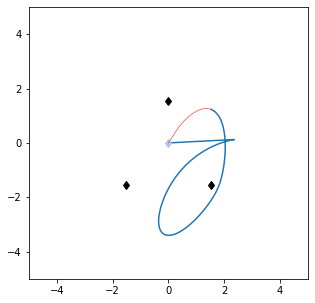

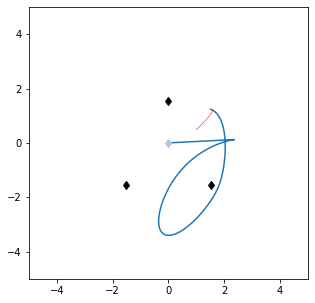

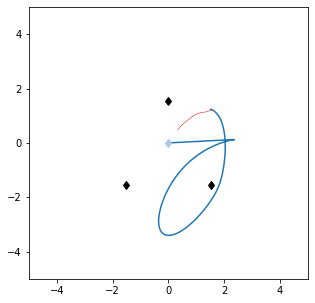

In [150]:
print(f'The length of the given sequence: {((simulation_test[good_indices[0]] != 0).sum(axis = 1) > 0).sum().item()} and the length of the prediction is {lengths_test[good_indices[0]].item()}')

plot_example(simulation_test[good_indices[0]], simulation_continued_test[good_indices[0]])
plot_example(simulation_test[good_indices[0]], predicted[good_indices[0]][:int(lengths_test[good_indices[0]].item())])
plot_example(simulation_test[good_indices[0]], predicted2[good_indices[0]][:int(lengths_test[good_indices[0]].item())])

The length of the given sequence: 99 and the length of the prediction is 22.0


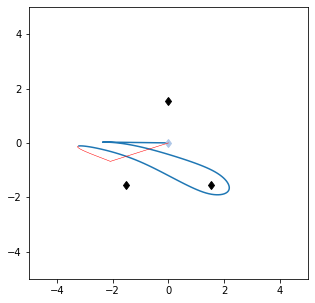

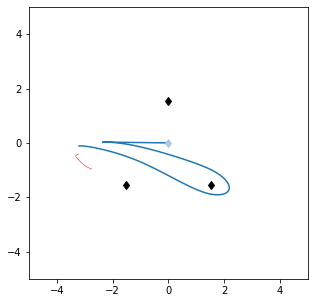

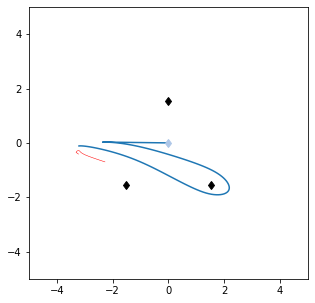

In [151]:
i = 1
print(f'The length of the given sequence: {((simulation_test[good_indices[i]] != 0).sum(axis = 1) > 0).sum().item()} and the length of the prediction is {lengths_test[good_indices[i]].item()}')

plot_example(simulation_test[good_indices[i]], simulation_continued_test[good_indices[i]])
plot_example(simulation_test[good_indices[i]], predicted[good_indices[i]][:int(lengths_test[good_indices[i]].item())])
plot_example(simulation_test[good_indices[i]], predicted2[good_indices[i]][:int(lengths_test[good_indices[i]].item())])

The length of the given sequence: 104 and the length of the prediction is 23.0


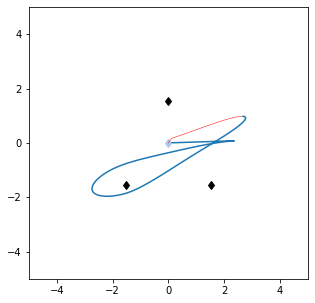

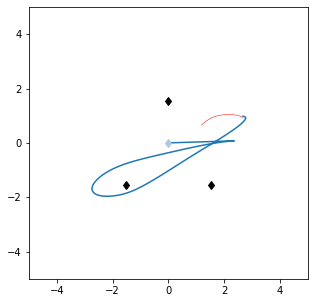

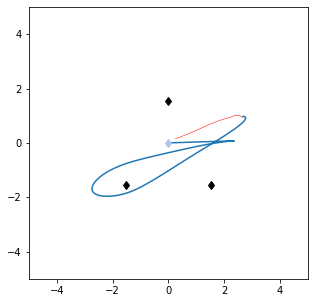

In [152]:
i = 2
print(f'The length of the given sequence: {((simulation_test[good_indices[i]] != 0).sum(axis = 1) > 0).sum().item()} and the length of the prediction is {lengths_test[good_indices[i]].item()}')

plot_example(simulation_test[good_indices[i]], simulation_continued_test[good_indices[i]])
plot_example(simulation_test[good_indices[i]], predicted[good_indices[i]][:int(lengths_test[good_indices[i]].item())])
plot_example(simulation_test[good_indices[i]], predicted2[good_indices[i]][:int(lengths_test[good_indices[i]].item())])

The length of the given sequence: 98 and the length of the prediction is 25.0


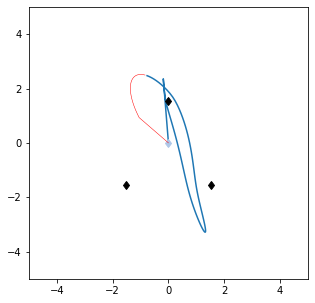

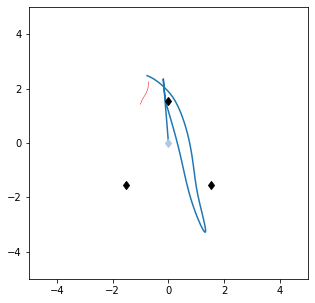

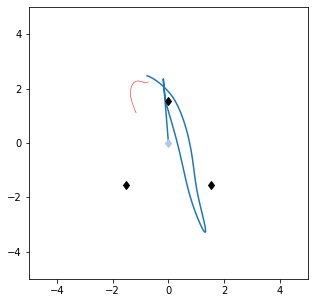

In [153]:
i = 3
print(f'The length of the given sequence: {((simulation_test[good_indices[i]] != 0).sum(axis = 1) > 0).sum().item()} and the length of the prediction is {lengths_test[good_indices[i]].item()}')

plot_example(simulation_test[good_indices[i]], simulation_continued_test[good_indices[i]])
plot_example(simulation_test[good_indices[i]], predicted[good_indices[i]][:int(lengths_test[good_indices[i]].item())])
plot_example(simulation_test[good_indices[i]], predicted2[good_indices[i]][:int(lengths_test[good_indices[i]].item())])

The length of the given sequence: 93 and the length of the prediction is 22.0


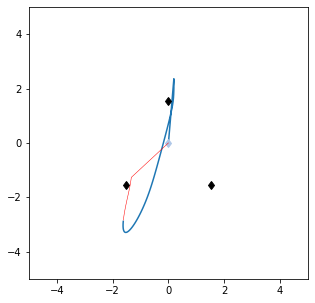

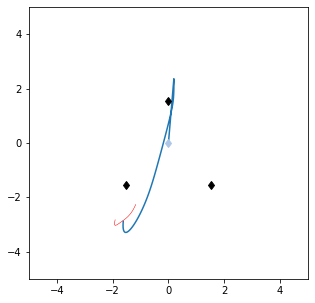

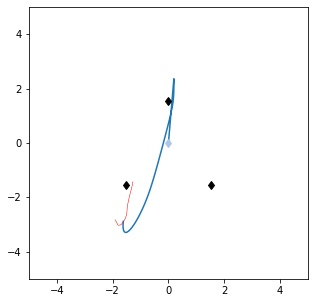

In [154]:
i = 4
print(f'The length of the given sequence: {((simulation_test[good_indices[i]] != 0).sum(axis = 1) > 0).sum().item()} and the length of the prediction is {lengths_test[good_indices[i]].item()}')

plot_example(simulation_test[good_indices[i]], simulation_continued_test[good_indices[i]])
plot_example(simulation_test[good_indices[i]], predicted[good_indices[i]][:int(lengths_test[good_indices[i]].item())])
plot_example(simulation_test[good_indices[i]], predicted2[good_indices[i]][:int(lengths_test[good_indices[i]].item())])

### Bad examples

The length of the given sequence: 95 and the length of the prediction is 59.0


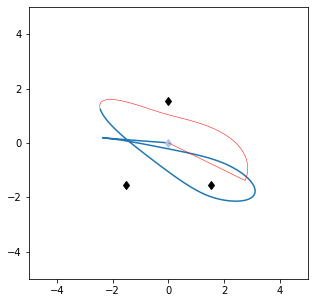

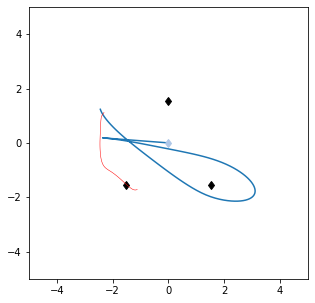

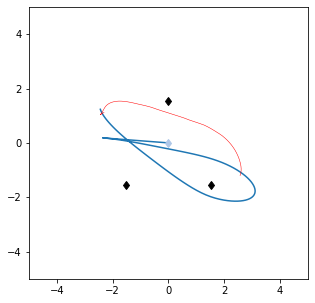

In [155]:
i = 0
print(f'The length of the given sequence: {((simulation_test[bad_indices[i]] != 0).sum(axis = 1) > 0).sum().item()} and the length of the prediction is {lengths_test[bad_indices[i]].item()}')

plot_example(simulation_test[bad_indices[i]], simulation_continued_test[bad_indices[i]])
plot_example(simulation_test[bad_indices[i]], predicted[bad_indices[i]][:int(lengths_test[bad_indices[i]].item())])
plot_example(simulation_test[bad_indices[i]], predicted2[bad_indices[i]][:int(lengths_test[bad_indices[i]].item())])


The length of the given sequence: 105 and the length of the prediction is 44.0


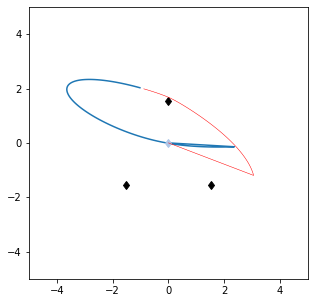

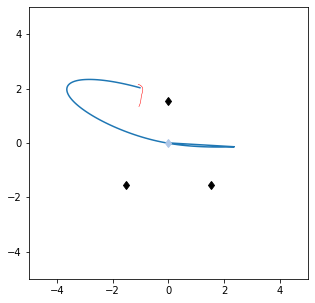

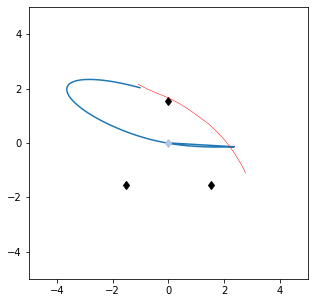

In [156]:
i = 1
print(f'The length of the given sequence: {((simulation_test[bad_indices[i]] != 0).sum(axis = 1) > 0).sum().item()} and the length of the prediction is {lengths_test[bad_indices[i]].item()}')

plot_example(simulation_test[bad_indices[i]], simulation_continued_test[bad_indices[i]])
plot_example(simulation_test[bad_indices[i]], predicted[bad_indices[i]][:int(lengths_test[bad_indices[i]].item())])
plot_example(simulation_test[bad_indices[i]], predicted2[bad_indices[i]][:int(lengths_test[bad_indices[i]].item())])


The length of the given sequence: 104 and the length of the prediction is 50.0


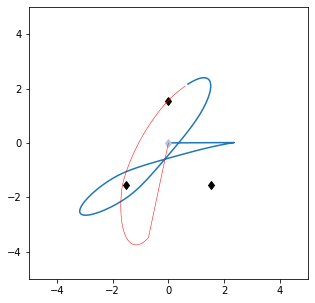

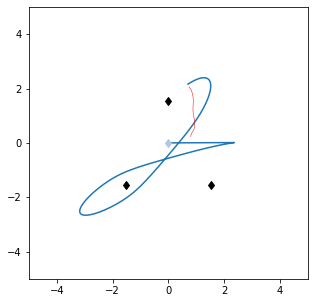

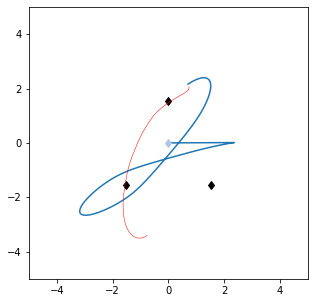

In [157]:
i = 2
print(f'The length of the given sequence: {((simulation_test[bad_indices[i]] != 0).sum(axis = 1) > 0).sum().item()} and the length of the prediction is {lengths_test[bad_indices[i]].item()}')

plot_example(simulation_test[bad_indices[i]], simulation_continued_test[bad_indices[i]])
plot_example(simulation_test[bad_indices[i]], predicted[bad_indices[i]][:int(lengths_test[bad_indices[i]].item())])
plot_example(simulation_test[bad_indices[i]], predicted2[bad_indices[i]][:int(lengths_test[bad_indices[i]].item())])


The length of the given sequence: 104 and the length of the prediction is 56.0


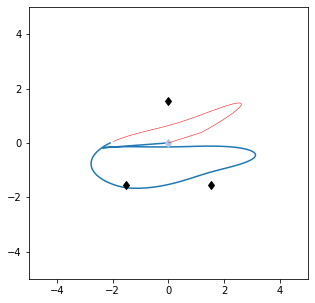

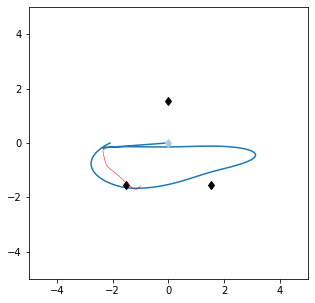

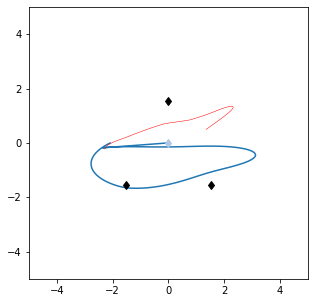

In [158]:
i = 3
print(f'The length of the given sequence: {((simulation_test[bad_indices[i]] != 0).sum(axis = 1) > 0).sum().item()} and the length of the prediction is {lengths_test[bad_indices[i]].item()}')

plot_example(simulation_test[bad_indices[i]], simulation_continued_test[bad_indices[i]])
plot_example(simulation_test[bad_indices[i]], predicted[bad_indices[i]][:int(lengths_test[bad_indices[i]].item())])
plot_example(simulation_test[bad_indices[i]], predicted2[bad_indices[i]][:int(lengths_test[bad_indices[i]].item())])


The length of the given sequence: 101 and the length of the prediction is 56.0


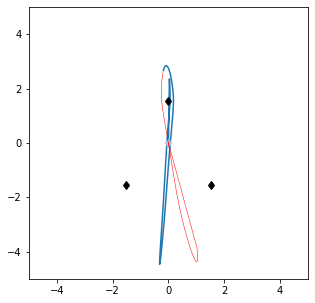

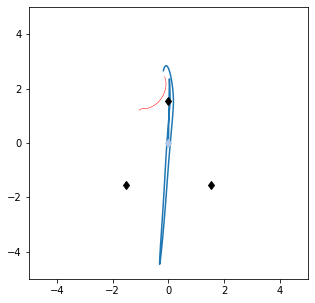

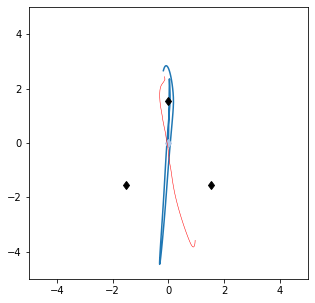

In [159]:
i = 4
print(f'The length of the given sequence: {((simulation_test[bad_indices[i]] != 0).sum(axis = 1) > 0).sum().item()} and the length of the prediction is {lengths_test[bad_indices[i]].item()}')

plot_example(simulation_test[bad_indices[i]], simulation_continued_test[bad_indices[i]])
plot_example(simulation_test[bad_indices[i]], predicted[bad_indices[i]][:int(lengths_test[bad_indices[i]].item())])
plot_example(simulation_test[bad_indices[i]], predicted2[bad_indices[i]][:int(lengths_test[bad_indices[i]].item())])